#Week-**4**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.appName("ETL").getOrCreate()
spark

#  Load employee attendance and task records into Databricks

In [5]:
from google.colab import files
uploaded = files.upload()  # Select attendance.csv, employees.csv, tasks.csv

Saving attendance.csv to attendance.csv
Saving employees.csv to employees.csv
Saving tasks.csv to tasks.csv


In [6]:
dfAtt = spark.read.csv("/content/attendance.csv", header=True, inferSchema=True)
dfEmp = spark.read.csv("/content/employees.csv", header=True, inferSchema=True)
dfTas = spark.read.csv("/content/tasks.csv", header=True, inferSchema=True)

In [7]:
dfAtt.printSchema()

root
 |-- attendanceID: integer (nullable = true)
 |-- employeeID: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- clockIN: string (nullable = true)
 |-- clockOUT: string (nullable = true)
 |-- isLate: integer (nullable = true)
 |-- isAbscent: integer (nullable = true)



In [8]:
dfEmp.printSchema()

root
 |-- employeeid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- role: string (nullable = true)
 |-- email: string (nullable = true)
 |-- hiredate: timestamp (nullable = true)
 |-- status: string (nullable = true)



In [9]:
dfTas.printSchema()

root
 |-- taskID: integer (nullable = true)
 |-- employeeID: integer (nullable = true)
 |-- taskName: string (nullable = true)
 |-- taskDate: date (nullable = true)
 |-- tasksCompeleted: integer (nullable = true)



# Cleaning Data
## *Unable to drop Null from dfAtt(Attendance) because clockin and clockout abscent data reperesented as Null values



In [10]:
dfEmp = dfEmp.dropna()
dfTas = dfTas.dropna()

#Combining data to create department-level metrics

In [11]:
dfJoined = dfAtt.join(dfEmp, on="employeeID", how="inner").join(dfTas, on="employeeID", how="inner")

In [12]:
dfJoined = dfJoined.filter(dfJoined.clockIN != "NULL")

In [13]:
dfJoined = dfJoined.withColumn(
    "hoursWorked",
    F.round(
        F.when(
            F.col("clockIN") != "NULL",
            F.unix_timestamp(F.col("clockOUT"), "dd-MM-yyyy HH:mm") - F.unix_timestamp(F.col("clockIN"), "dd-MM-yyyy HH:mm")
        ).otherwise(0) / 3600,2)) \
    .withColumn(
        "productivityScore",
        F.when(F.col("hoursWorked") > 0,(F.round(F.col("tasksCompeleted") / F.col("hoursWorked"), 2))).otherwise(0))

In [14]:
deptMetrics = dfJoined.groupBy("department") \
.agg(
        F.sum("isLate").alias("LateCount"),
        F.sum("isAbscent").alias("AbscentCount"),
        F.round(F.mean("hoursWorked"), 2).alias("AverageWorkHours"),
        F.round(F.mean("productivityScore"), 2).alias("AverageProductivityScore"),
        F.sum("tasksCompeleted").alias("TotalTasksCompleted"))
deptMetrics.show()

+-----------+---------+------------+----------------+------------------------+-------------------+
| department|LateCount|AbscentCount|AverageWorkHours|AverageProductivityScore|TotalTasksCompleted|
+-----------+---------+------------+----------------+------------------------+-------------------+
|    finance|       12|           0|            8.25|                    0.26|                 80|
|  marketing|       12|           0|            8.21|                    0.36|                110|
|         hr|       12|           0|            8.33|                    0.11|                 35|
|engineering|       24|           0|            8.23|                     0.4|                245|
+-----------+---------+------------+----------------+------------------------+-------------------+



# Save output in CSV format for visualization/dashboard use

In [16]:
from google.colab import drive
drive.mount('/content/drive')

deptMetrics.write.mode("overwrite").csv("/content/drive/MyDrive/deptMetrics")

Mounted at /content/drive


# Visualization

In [22]:
print(visual.columns)

Index(['department', 'LateCount', 'AbscentCount', 'AverageWorkHours',
       'AverageProductivityScore', 'TotalTasksCompleted'],
      dtype='object')


<Axes: xlabel='department'>

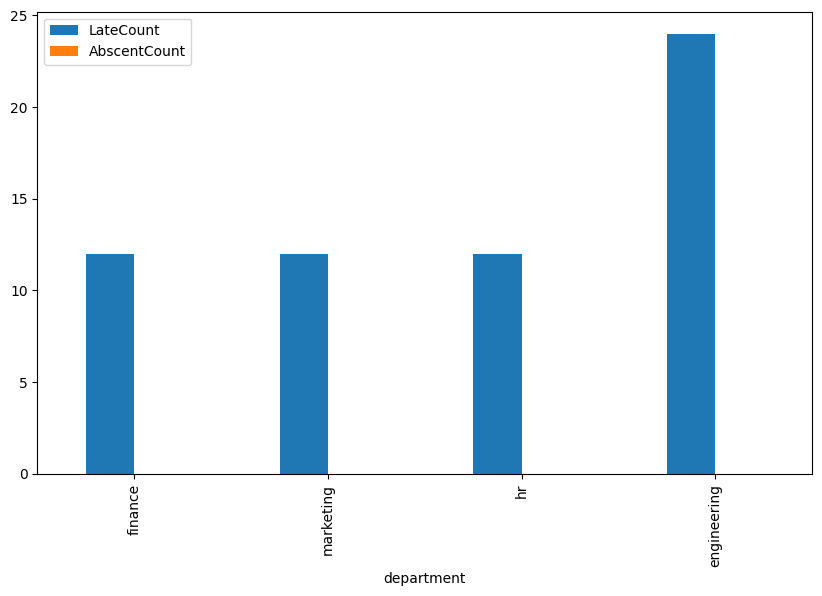

In [25]:
visual = deptMetrics.toPandas()
visual.plot.bar(x="department", y=["LateCount", "AbscentCount"], figsize=(10,6))

<Axes: xlabel='department'>

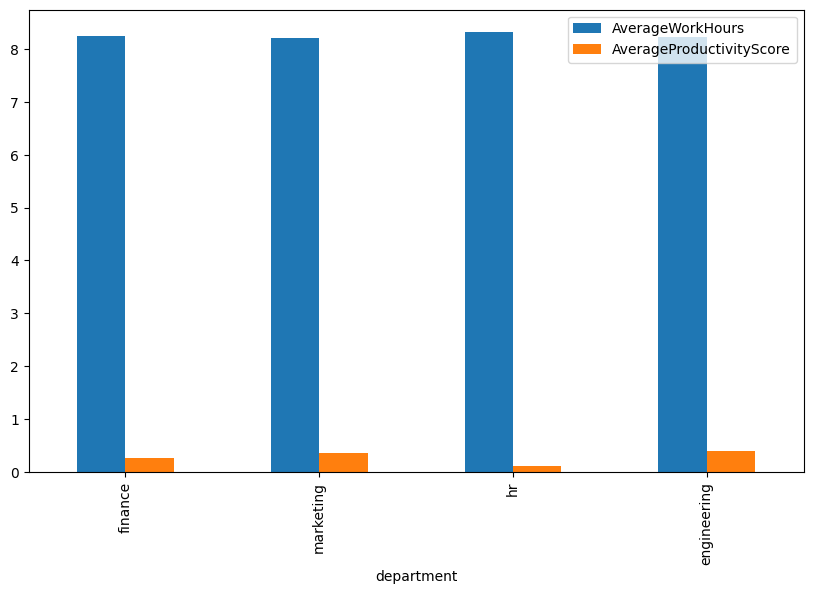

In [26]:
visual.plot.bar(x="department", y=["AverageWorkHours", "AverageProductivityScore"], figsize=(10,6))

<Axes: ylabel='TotalTasksCompleted'>

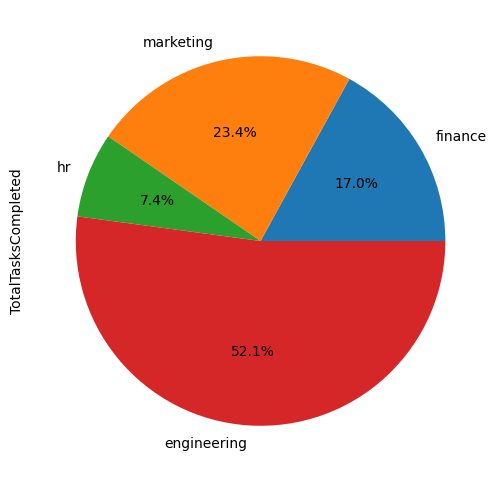

In [27]:
visual.set_index("department")["TotalTasksCompleted"].plot.pie(
    autopct="%1.1f%%", figsize=(10, 6))

#Deliverables
### DataBricks notebook with full ETL process
### Exported file showing attendance and task KPIs

In [ ]:
# 1. Full ETL databricks ipynb notbook is attached to git repo under week-4 folder

In [33]:
# 2. Exporting task and attendance KPI's
import shutil
from google.colab import files

# Attendance KPI
deptMetrics.select(["department", "LateCount", "AbscentCount", "AverageWorkHours"]) \
    .write.mode("overwrite").option("header", True) \
    .csv("/content/attendanceKPI")

# Department Metrics full dataset
deptMetrics.write.mode("overwrite").option("header", True) \
    .csv("/content/deptMetrics")

# Task KPI
deptMetrics.select(["department", "AverageProductivityScore", "TotalTasksCompleted"]) \
    .write.mode("overwrite").option("header", True) \
    .csv("/content/taskKPI")

# Zip the folders
shutil.make_archive("/content/attendanceKPI", 'zip', "/content/attendanceKPI")
shutil.make_archive("/content/deptMetrics", 'zip', "/content/deptMetrics")
shutil.make_archive("/content/taskKPI", 'zip', "/content/taskKPI")

# Download the zipped folders
files.download("/content/attendanceKPI.zip")
files.download("/content/deptMetrics.zip")
files.download("/content/taskKPI.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>